In [27]:
ENERGY_INTENSITY_STORAGE_KWH_PER_GB = 0.0046 # kWh/GB


In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown
import math
from scipy.interpolate import interp1d

import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Test

In [3]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."


yaml_files = sorted(
    (f for f in os.listdir("reports") if f.lower().endswith(".yaml")),
    key=lambda fn: os.path.getmtime(path.join("reports", fn))
)

if not yaml_files:
    raise RuntimeError("No .yaml reports found in reports/")

# sort them by date
yaml_files.sort(key=lambda x: path.getctime(path.join("reports",x)))
yaml_files = yaml_files[::-1]

# Load the last experiment
last_experiment = yaml_files[0]

report_path = path.join("reports", last_experiment)
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not [], "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not [], "No interactions found."
assert report.interactions[0] is not [], "No interactions found. "
assert report.interactions[0].response_data is not [], "No data in interaction found"


Loaded report report_2025-06-22_08-32-42.yaml


In [4]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_storage_pods = []
cached_dataframes_storage_namespace = []

In [5]:
# invert the files_in_direcotry list 
#files_in_direcotory = files_in_direcotory[::-1]

experiments_map = {
    "recommendation_k8_base_1m_otel": None,
    "recommendation_k8_base_1s_otel": None,
    "recommendation_k8_base_5_percent": None,
    "recommendation_k8_base_10_percent": None,
    "recommendation_k8_base_50_percent": None,
}


# iterate over all reports and find a string in them
print("Searching for most recent experiments in list of reports " + len(yaml_files).__str__())
for file in yaml_files:
    report_path = path.join("reports", file)
    # read the file as a string
    with open(report_path, "r") as f:
        content = f.read()
        # iterate over all experiments and check if the string contains the experiment name
        
        for experiment in experiments_map.keys():
            if experiment in content:
                if experiments_map[experiment]:
                    print(f"Found {experiment} in {file} but already found in {experiments_map[experiment]}. Did the recent run not included all experiments?")
                    continue
                experiments_map[experiment] = file
                print(f"Found {experiment} in {file}")
                break
    
    if all(experiments_map.values()):
        print("All experiments found")
        break
        

Searching for most recent experiments in list of reports 32
Found recommendation_k8_base_50_percent in report_2025-06-22_08-32-42.yaml
Found recommendation_k8_base_10_percent in report_2025-06-22_08-03-41.yaml
Found recommendation_k8_base_5_percent in report_2025-06-22_07-34-30.yaml
Found recommendation_k8_base_1s_otel in report_2025-06-22_07-05-31.yaml
Found recommendation_k8_base_1m_otel in report_2025-06-22_06-36-30.yaml
All experiments found


Loading some basic functions used later on

In [19]:

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    print(interaction)
                    print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"

                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time


def plot_storage_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    print(combined_df)
    # Get unique container names
    container_names = combined_df["label_app_kubernetes_io_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")
    sns.set_palette("pastel")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # hue is the list of all unique treatments
    hue = combined_df["treatment"].unique()
    
    # use a lowpass filter to smooth the data
    combined_df[response_name] = combined_df[response_name].rolling(window=6, center=True, min_periods=2).mean()
   
        

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["label_app_kubernetes_io_name"] == container_name]
        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                # if there is an  error in interp1d then just skip this one
                try:
                    f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                except:
                    continue 
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                sns.lineplot(
                    x=experiment_seconds_new,
                    y=response_interpolated,
                    ax=ax,
                    label=f"{df['label'].iloc[0]}",
                    linewidth=2
                )
            else:
                print(f"Only one data point for {container_name} in treatment {treatment}.")
                """ sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                ) """

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel("Watt")
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()



In [14]:
# uncomment to reset cache
cached_dataframes_kepler_namespace = []


# Directory containing reports
report_directory = "reports"
treatment_names = ["delay_treatment", "empty_treatment"]
#                       baseline                                    5% base                                                10% base                                                      50% base                                            1s
report_names = [experiments_map["recommendation_k8_base_1m_otel"], experiments_map["recommendation_k8_base_5_percent"],   experiments_map["recommendation_k8_base_10_percent"],experiments_map["recommendation_k8_base_50_percent"], experiments_map["recommendation_k8_base_1s_otel"]]
REPORT_LABELS = {report_names[0]: "Baseline", report_names[1]: "5% Base",  report_names[2]: "10% Base",  report_names[3]: "50% Base", report_names[4]: "1s"}


response_name_storage_namespace_combined_absolute = "cadvisor_storage_usage_combined_absolute"


# Storage Energy

In [20]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_sampling_5_percent = load_report_interactions(report_directory, report_names[1], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_base_10_percent = load_report_interactions(report_directory, report_names[2], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_base_50_percent = load_report_interactions(report_directory, report_names[3], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_base_1s = load_report_interactions(report_directory, report_names[4], response_name_storage_namespace_combined_absolute, "empty_treatment")

[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=Metr

Using cached dataframes.
                              label_app_kubernetes_io_name  \
timestamp                                                    
2025-06-22 04:36:33.648999929                   accounting   
2025-06-22 04:37:03.648999929                   accounting   
2025-06-22 04:37:33.648999929                   accounting   
2025-06-22 04:38:03.648999929                   accounting   
2025-06-22 04:38:33.648999929                   accounting   
...                                                    ...   
2025-06-22 05:28:34.720999956                  valkey-cart   
2025-06-22 05:29:04.720999956                  valkey-cart   
2025-06-22 05:29:34.720999956                  valkey-cart   
2025-06-22 05:30:04.720999956                  valkey-cart   
2025-06-22 05:30:34.720999956                  valkey-cart   

                                             namespace     timestamp  \
timestamp                                                              
2025-06-22 04:36:33.6489

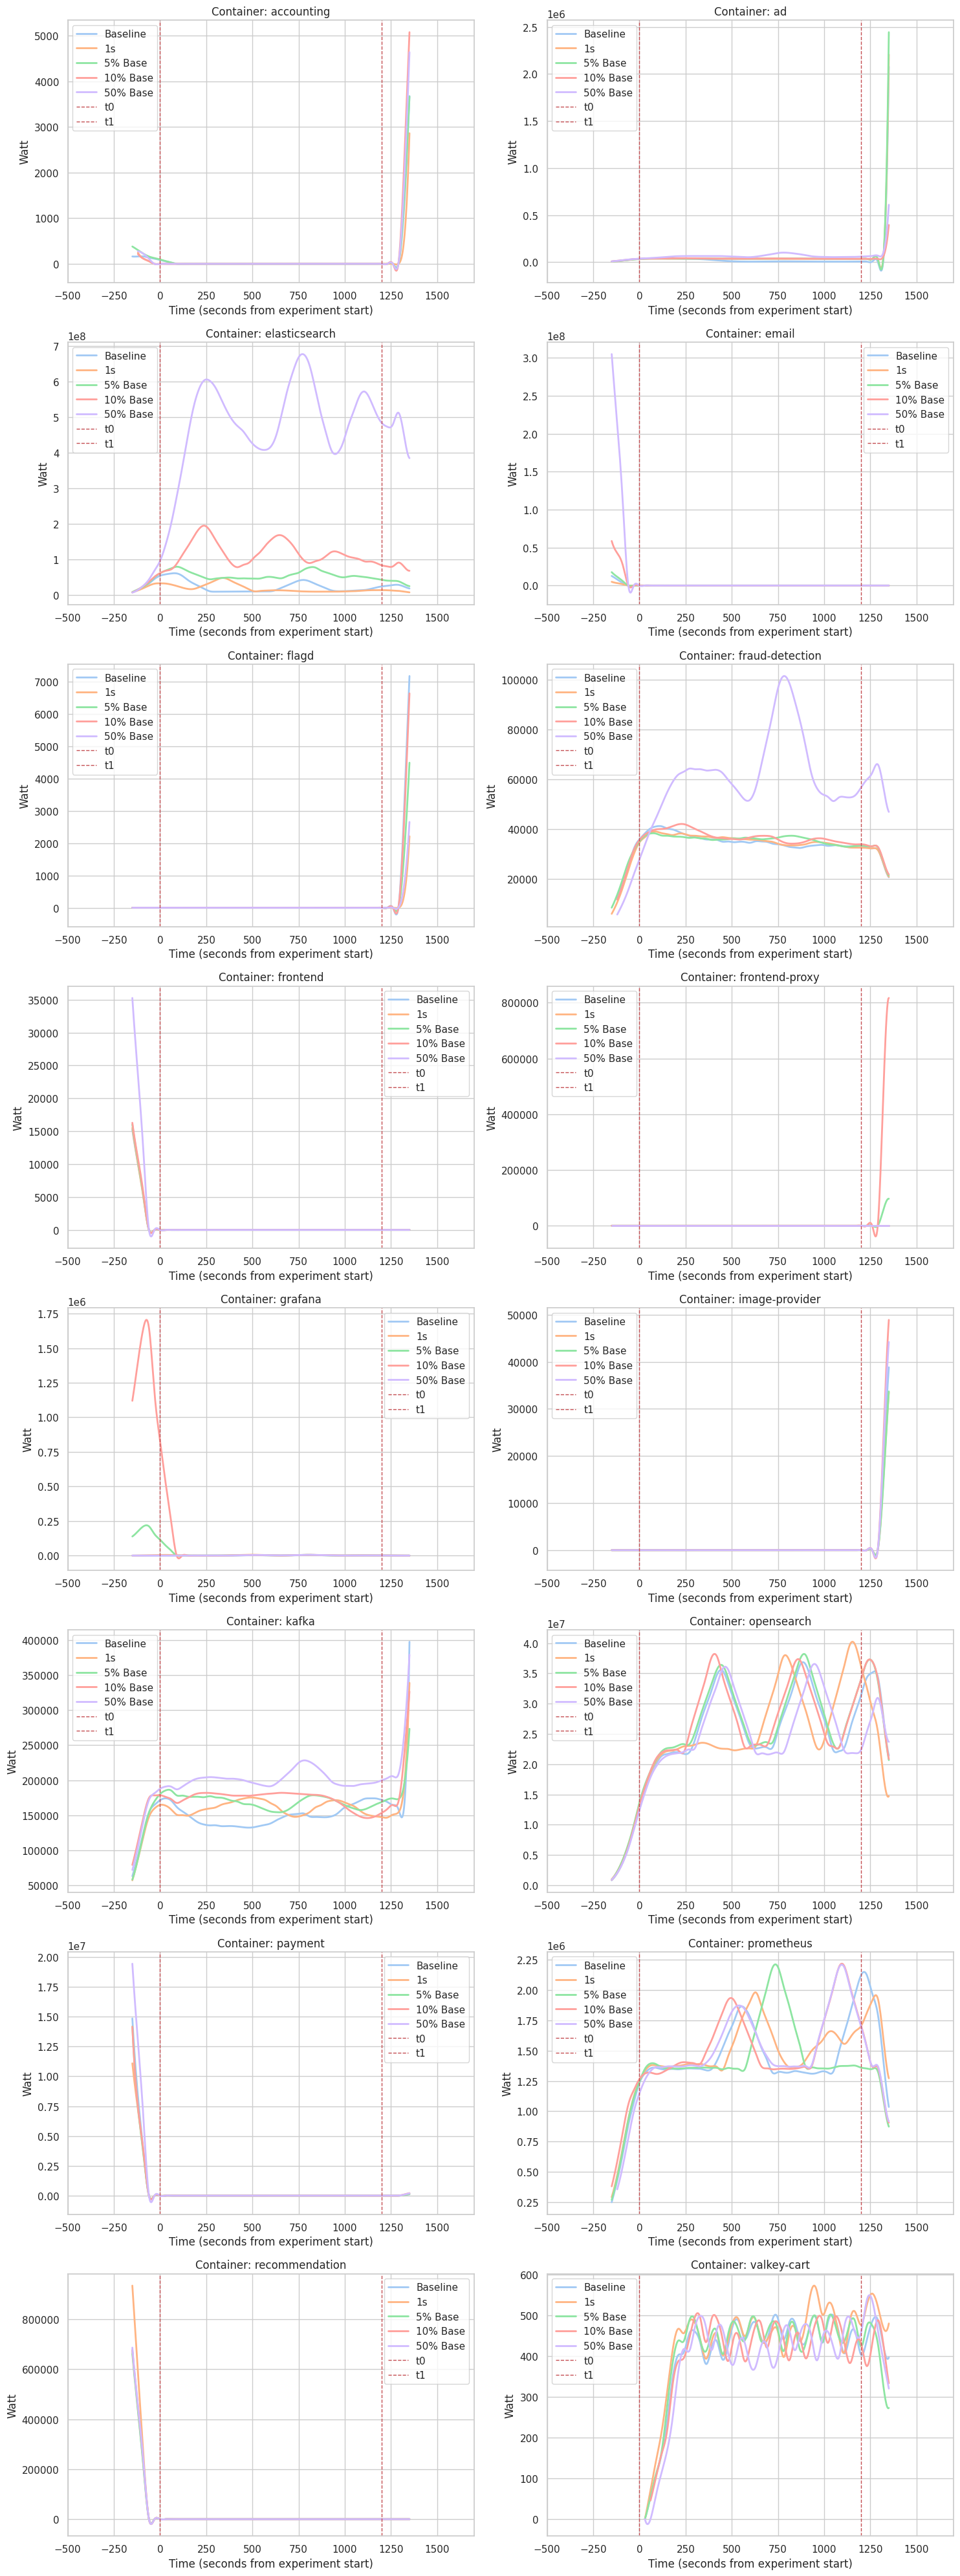

In [21]:

cached_dataframes_storage_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_storage_pods, report_directory, "cadvisor_storage_usage_all", treatment_names, report_names)

plot_storage_metrics_per_pod_seaborn(combined_df, "cadvisor_storage_usage_all", treatment_end_time, treatment_start_time)

In [24]:
def get_storage_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    for container_namespace, df in interaction.response_data.groupby("namespace"):
        treatment_df = df[df[treatment_name] == treatment_name]
        if not treatment_df.empty:
            # get the first and last value of the treatment
            treatment_start = treatment_df[response_name_storage_namespace_combined_absolute].iloc[0]
            treatment_end = treatment_df[response_name_storage_namespace_combined_absolute].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_namespace] = (treatment_start, treatment_end, difference)
    return treatment_start_end_values

treatment_start_end = {}

report_base_storage_namespace = get_storage_energy_consumption(report_base, "empty_treatment")
report_sampling_5_percent_storage_namespace = get_storage_energy_consumption(report_sampling_5_percent, "empty_treatment")
report_base_10_percent_storage_namespace = get_storage_energy_consumption(report_base_10_percent, "empty_treatment")
report_base_50_percent_storage_namespace = get_storage_energy_consumption(report_base_50_percent, "empty_treatment")
report_base_1s_storage_namespace = get_storage_energy_consumption(report_base_1s, "empty_treatment")

for container_namespace, values in report_base_storage_namespace.items():
    percentage_differece_sampling = (report_sampling_5_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_difference_base_10_percent = (report_base_10_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_base_50_percent = (report_base_50_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_base_1s = (report_base_1s_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    
    print(f"Namespace: {container_namespace}")
    print(f"Base Treatment: {report_base_storage_namespace[container_namespace][2]}")
    print(f"Sampling 5% Treatment: {report_sampling_5_percent_storage_namespace[container_namespace][2]} ({percentage_differece_sampling:.2f}%)")
    print(f"Base 10% Treatment: {report_base_10_percent_storage_namespace[container_namespace][2]} ({percentage_difference_base_10_percent:.2f}%)")
    print(f"Base 50% Treatment: {report_base_50_percent_storage_namespace[container_namespace][2]} ({percentage_differece_base_50_percent:.2f}%)")
    print(f"Base 1s Treatment: {report_base_1s_storage_namespace[container_namespace][2]} ({percentage_differece_base_1s:.2f}%)")
    
    print("-----------------------------------------------")

Namespace: system-under-evaluation
Base Treatment: 55891644416
Sampling 5% Treatment: 96106446848 (71.95%)
Base 10% Treatment: 174742769664 (212.65%)
Base 50% Treatment: 631038681088 (1029.04%)
Base 1s Treatment: 55129047040 (-1.36%)
-----------------------------------------------


In [25]:
report_base_storage_per_pod = load_report_interactions(report_directory, report_names[0], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_sampling_5_percent_storage_per_pod = load_report_interactions(report_directory, report_names[1], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_base_10_percent_storage_per_pod = load_report_interactions(report_directory, report_names[2], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_base_50_percent_storage_per_pod = load_report_interactions(report_directory, report_names[3], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_base_1s_storage_per_pod = load_report_interactions(report_directory, report_names[4], "cadvisor_storage_usage_all_absolute", "empty_treatment")

[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=Metr

In [28]:
def get_storage_energy_consumption_per_pod(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["label_app_kubernetes_io_name"].unique())
    print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("label_app_kubernetes_io_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]

        # cut off the first and last 10% of the data
        treatment_df = df.iloc[int(len(df) * 0.1):int(len(df) * 0.9)]
    
        
        if not treatment_df.empty:
            # TODO: use increase() in prometheus query instead of fixing it here
            # the values are normally monotonic increasing, but there are some exceptions where the values resets to 0 and starts again
            # so we have to check if each following value is greater than the previous one and if not, then we have to add the difference
            
            # Extract the column into a separate series to avoid chained assignment
            column = treatment_df["cadvisor_storage_usage_all_absolute"].copy()

            # Iterate through the series to fix monotonicity
            for i in range(1, len(column)):
                if column.iloc[i] < column.iloc[i - 1]:
                    print(f"Container: {container_name}, Found break in monotonicity at index {i}. Fixing it.")
                    # Calculate the difference and propagate it to all subsequent values
                    difference = column.iloc[i - 1] - column.iloc[i]
                    column.iloc[i:] += difference

            # Assign the fixed series back to the DataFrame
            treatment_df["cadvisor_storage_usage_all_absolute"] = column
            
            
            # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_storage_usage_all_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_storage_usage_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")
            # set to 0 if no treatment period found
            treatment_start_end_values[container_name] = (-1, -1, -1)

    return treatment_start_end_values

values_base_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_storage_per_pod, "empty_treatment")
values_sampling_5_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_sampling_5_percent_storage_per_pod, "empty_treatment")
values_base_10_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_10_percent_storage_per_pod, "empty_treatment")
values_base_50_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_50_percent_storage_per_pod, "empty_treatment")
values_base_1s_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_1s_storage_per_pod, "empty_treatment")


for container_name, values in values_base_storage_per_pod.items():
    if  not container_name in values_sampling_5_percent_storage_per_pod:
        print(f"Container {container_name} not found in all treatments.")
        continue
    percentage_differece_sampling = (values_sampling_5_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_difference_base_10_percent = (values_base_10_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_base_50_percent = (values_base_50_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_base_1s = (values_base_1s_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {values_base_storage_per_pod[container_name][2]}")
    print(f"Sampling 5% Treatment: {values_sampling_5_percent_storage_per_pod[container_name][2]} ({percentage_differece_sampling:.2f}%)")
    print(f"Base 10% Treatment: {values_base_10_percent_storage_per_pod[container_name][2]} ({percentage_difference_base_10_percent:.2f}%)")
    print(f"Base 50% Treatment: {values_base_50_percent_storage_per_pod[container_name][2]} ({percentage_differece_base_50_percent:.2f}%)")
    print("-----------------------------------------------")

# sum up the values for all containers for each different report
sum_base = sum([values_base_storage_per_pod[container_name][2] for container_name in values_base_storage_per_pod])
sum_sampling_5_percent = sum([values_sampling_5_percent_storage_per_pod[container_name][2] for container_name in values_sampling_5_percent_storage_per_pod])
sum_base_10_percent = sum([values_base_10_percent_storage_per_pod[container_name][2] for container_name in values_base_10_percent_storage_per_pod])
sum_base_50_percent = sum([values_base_50_percent_storage_per_pod[container_name][2] for container_name in values_base_50_percent_storage_per_pod])
sum_base_1s = sum([values_base_1s_storage_per_pod[container_name][2] for container_name in values_base_1s_storage_per_pod])

percentage_differece_sampling = (sum_sampling_5_percent - sum_base) / sum_base * 100
percentage_difference_base_10_percent = (sum_base_10_percent - sum_base) / sum_base * 100
percentage_differece_base_50_percent = (sum_base_50_percent - sum_base) / sum_base * 100
percentage_differece_base_1s = (sum_base_1s - sum_base) / sum_base * 100

print(f"Sum of all containers")
print(f"Base Treatment: {sum_base}")
print(f"Sampling 5% Treatment: {sum_sampling_5_percent} ({percentage_differece_sampling:.2f}%)")
print(f"Base 10% Treatment: {sum_base_10_percent} ({percentage_difference_base_10_percent:.2f}%)")
print(f"Base 50% Treatment: {sum_base_50_percent} ({percentage_differece_base_50_percent:.2f}%)")
print("-----------------------------------------------")


# calc median, average and percentlies of all containers
base_values = [values_base_storage_per_pod[container_name][2] for container_name in values_base_storage_per_pod]
sampling_5_percent_values = [values_sampling_5_percent_storage_per_pod[container_name][2] for container_name in values_sampling_5_percent_storage_per_pod]
base_10_percent_values = [values_base_10_percent_storage_per_pod[container_name][2] for container_name in values_base_10_percent_storage_per_pod]
base_50_percent_values = [values_base_50_percent_storage_per_pod[container_name][2] for container_name in values_base_50_percent_storage_per_pod]
base_1s_values = [values_base_1s_storage_per_pod[container_name][2] for container_name in values_base_1s_storage_per_pod]

print(f"Base Treatment: Median: {np.median(base_values)}, Mean: {np.mean(base_values)}, 90th Percentile: {np.percentile(base_values, 90)}")
print(f"Sampling 5% Treatment: Median: {np.median(sampling_5_percent_values)}, Mean: {np.mean(sampling_5_percent_values)}, 90th Percentile: {np.percentile(sampling_5_percent_values, 90)}")
print(f"Base 10% Treatment: Median: {np.median(base_10_percent_values)}, Mean: {np.mean(base_10_percent_values)}, 90th Percentile: {np.percentile(base_10_percent_values, 90)}")
print(f"Base 50% Treatment: Median: {np.median(base_50_percent_values)}, Mean: {np.mean(base_50_percent_values)}, 90th Percentile: {np.percentile(base_50_percent_values, 90)}")
print(f"Base 1s Treatment: Median: {np.median(base_1s_values)}, Mean: {np.mean(base_1s_values)}, 90th Percentile: {np.percentile(base_1s_values, 90)}")


print("-----------------------------------------------")

# calculate the energy consumption in kWh
energy_base = (sum_base/1000/1000/1000) * ENERGY_INTENSITY_STORAGE_KWH_PER_GB
energy_base_1s = (sum_base_1s/1000/1000/1000) * ENERGY_INTENSITY_STORAGE_KWH_PER_GB
energy_10_percent = (sum_base_10_percent/1000/1000/1000) * ENERGY_INTENSITY_STORAGE_KWH_PER_GB
energy_50_percent = (sum_base_50_percent/1000/1000/1000) * ENERGY_INTENSITY_STORAGE_KWH_PER_GB

print(f"Energy consumption Base Treatment: {energy_base} kWh")
print(f"Energy consumption Base 1s Treatment: {energy_base_1s} kWh")
print(f"Energy consumption Base 10% Treatment: {energy_10_percent} kWh")
print(f"Energy consumption Base 50% Treatment: {energy_50_percent} kWh")


Interaction: empty_treatment with 16 containers
Interaction: empty_treatment with 16 containers
Interaction: empty_treatment with 16 containers
Interaction: empty_treatment with 16 containers
Interaction: empty_treatment with 16 containers
Container: accounting
Base Treatment: 0
Sampling 5% Treatment: 0 (nan%)
Base 10% Treatment: 0 (nan%)
Base 50% Treatment: 0 (nan%)
-----------------------------------------------
Container: ad
Base Treatment: 20643840
Sampling 5% Treatment: 46104576 (123.33%)
Base 10% Treatment: 46546944 (125.48%)
Base 50% Treatment: 79036416 (282.86%)
-----------------------------------------------
Container: elasticsearch
Base Treatment: 25366007808
Sampling 5% Treatment: 67703037952 (166.90%)
Base 10% Treatment: 140584185856 (454.22%)
Base 50% Treatment: 601930498048 (2272.98%)
-----------------------------------------------
Container: email
Base Treatment: 0
Sampling 5% Treatment: 0 (nan%)
Base 10% Treatment: 0 (nan%)
Base 50% Treatment: 0 (nan%)
-----------------

/tmp/ipykernel_2739456/1744012230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_2739456/1744012230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_2739456/1744012230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

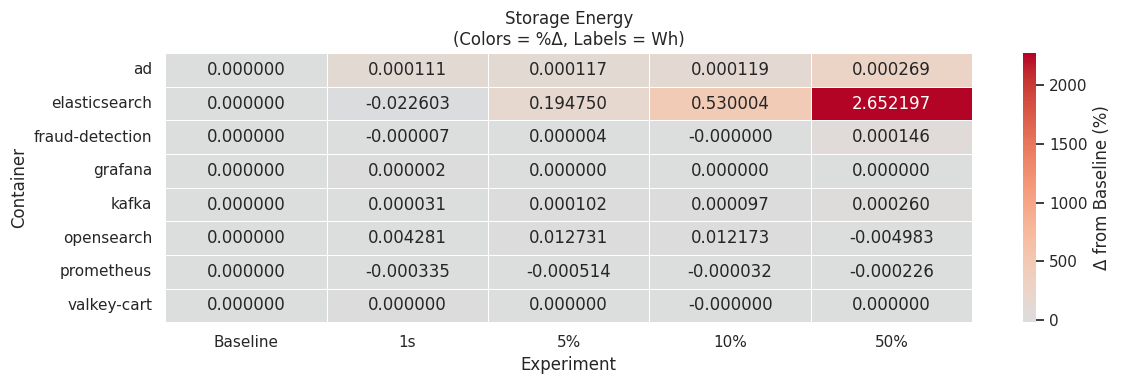

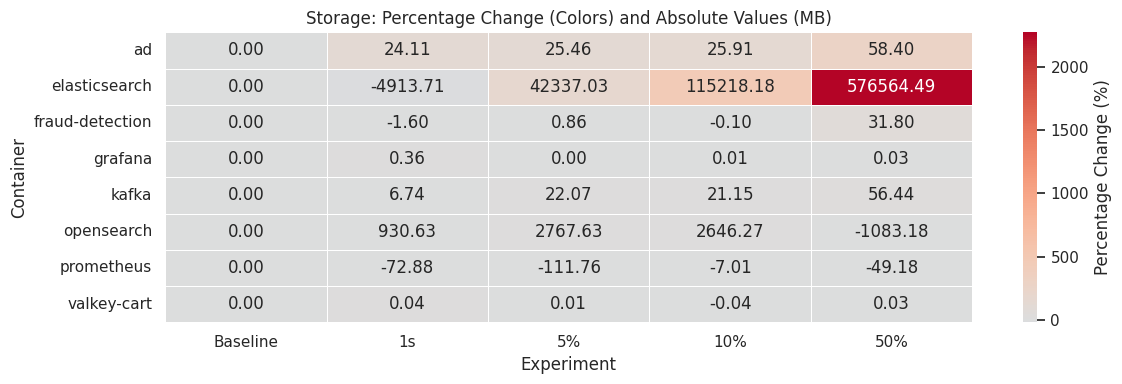

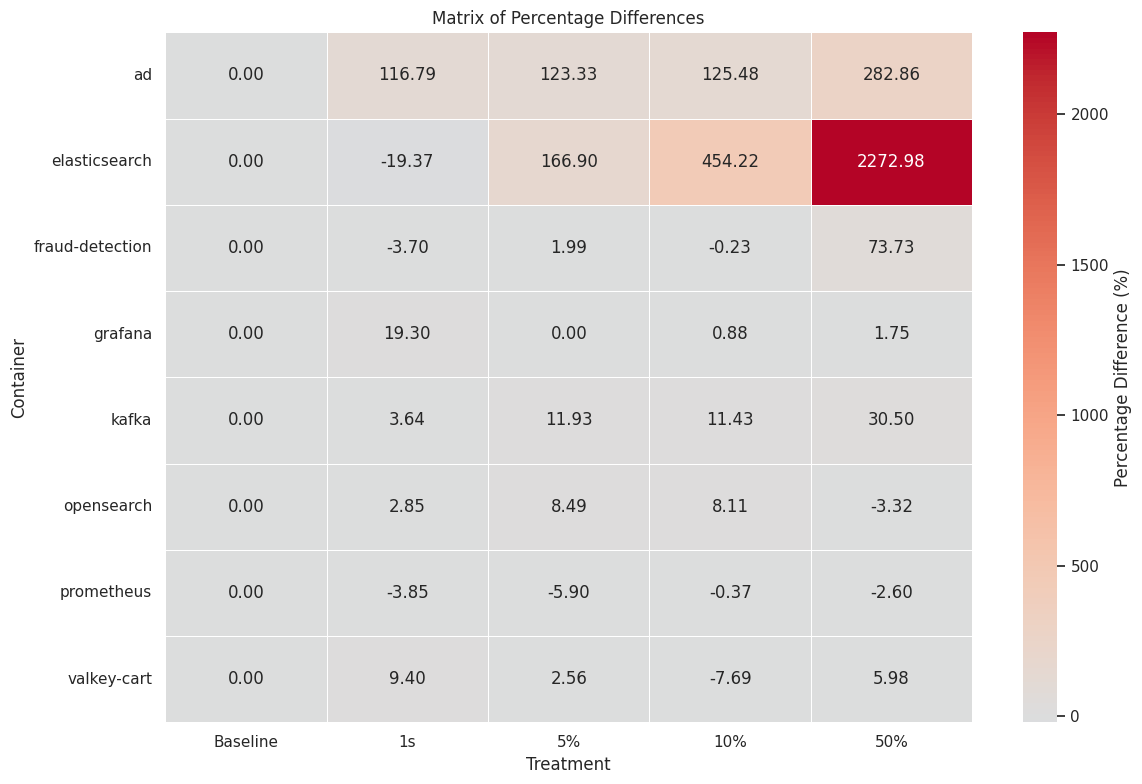

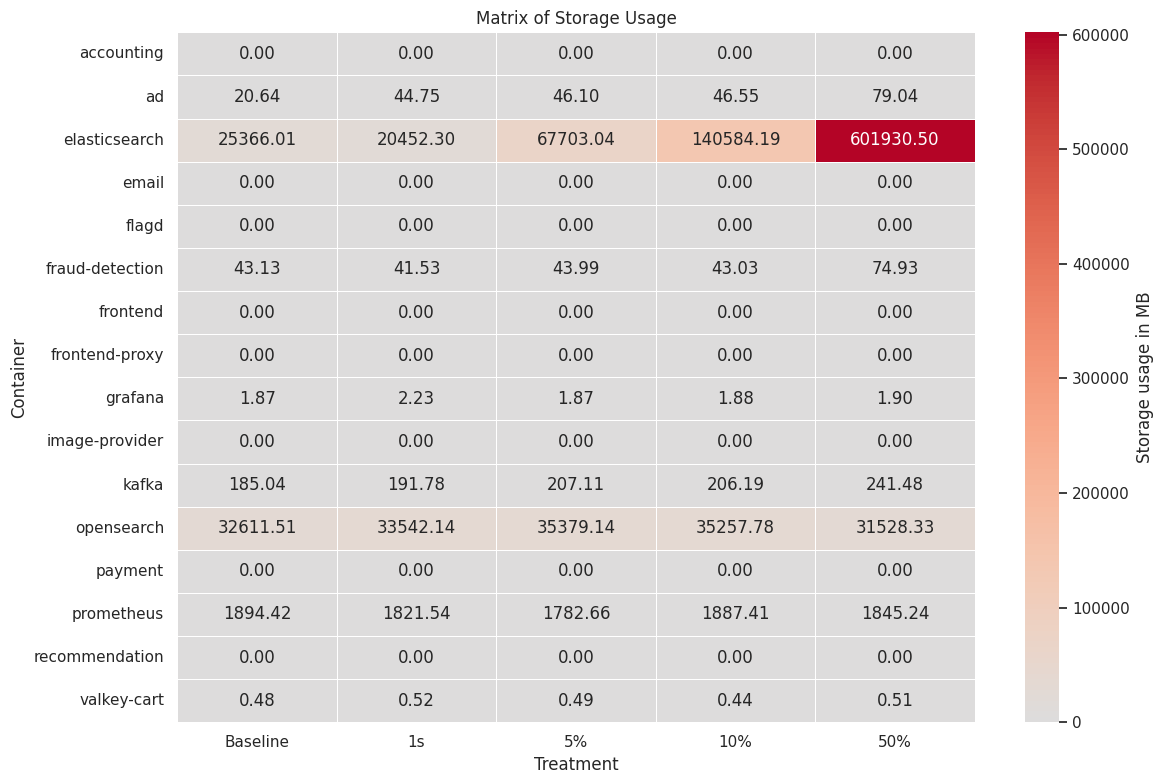

In [31]:
import math


def generate_difference_matrix_baseline_kwh(
    base_dict,
    storage_1s_dict,
    five_percent_dict,
    ten_percent_dict,
    fifty_percent_dict,
    value_index=2,
    energy_intensity_gb_to_kwh=ENERGY_INTENSITY_STORAGE_KWH_PER_GB,
    save_path='evaluation/plots/storage_percentage_change_kwh.png',
    figsize=(12, 4)
):
    """
    Heatmap of percentage changes (colors) and absolute kWh differences (annotations)
    for storage energy across experiments.
    """
    # Identify containers common to all inputs
    dicts = [base_dict, storage_1s_dict, five_percent_dict, ten_percent_dict, fifty_percent_dict]
    common = set(base_dict)
    for d in dicts[1:]:
        common &= set(d)
    if not common:
        raise ValueError("No common containers found across all inputs.")

    # Build DataFrame
    experiments = {
        'Baseline': base_dict,
        '1s': storage_1s_dict,
        '5%': five_percent_dict,
        '10%': ten_percent_dict,
        '50%': fifty_percent_dict,
    }
    data = {exp: {c: d[c][value_index] for c in common} for exp, d in experiments.items()}
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Convert bytes -> MB -> GB -> kWh
    df_mb = (df / 1e6).round(2)
    df_gb = df_mb / 1e3
    df_kwh = df_gb * energy_intensity_gb_to_kwh

    # Percentage change from baseline
    pct = df_mb.sub(df_mb['Baseline'], axis=0).div(df_mb['Baseline'], axis=0).mul(100)
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    pct.dropna(how='any', inplace=True)

    # Absolute difference in kWh for annotations
    abs_diff = df_kwh.sub(df_kwh['Baseline'], axis=0).loc[pct.index]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        pct,
        annot=abs_diff,
        fmt='.6f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Δ from Baseline (%)'}
    )
    plt.title("Storage Energy\n(Colors = %Δ, Labels = Wh)")
    plt.xlabel("Experiment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


def generate_difference_matrix_percentage(
    base_dict,
    one_s_dict,
    five_percent_dict,
    ten_percent_dict,
    fifty_percent_dict,
    value_index=2,
    figsize=(12, 8)
):
    """
    Heatmap of percentage differences (in %) from baseline for each experiment.
    """
    # Common containers
    dicts = [base_dict, one_s_dict, five_percent_dict, ten_percent_dict, fifty_percent_dict]
    common = set(base_dict)
    for d in dicts[1:]:
        common &= set(d)
    if not common:
        raise ValueError("No common containers found across all inputs.")

    experiments = {
        'Baseline': base_dict,
        '1s': one_s_dict,
        '5%': five_percent_dict,
        '10%': ten_percent_dict,
        '50%': fifty_percent_dict,
    }
    data = {exp: {c: d[c][value_index] for c in common} for exp, d in experiments.items()}
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Percentage difference from baseline
    pct = df.sub(df['Baseline'], axis=0).div(df['Baseline'], axis=0).mul(100)
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    pct.dropna(how='any', inplace=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        pct,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix(
    base_dict,
    one_s_dict,
    five_percent_dict,
    ten_percent_dict,
    fifty_percent_dict,
    value_index=2,
    figsize=(12, 8)
):
    """
    Heatmap of absolute storage usage in MB for each experiment.
    """
    # Common containers
    dicts = [base_dict, one_s_dict, five_percent_dict, ten_percent_dict, fifty_percent_dict]
    common = set(base_dict)
    for d in dicts[1:]:
        common &= set(d)
    if not common:
        raise ValueError("No common containers found across all inputs.")

    experiments = {
        'Baseline': base_dict,
        '1s': one_s_dict,
        '5%': five_percent_dict,
        '10%': ten_percent_dict,
        '50%': fifty_percent_dict,
    }
    data = {exp: {c: d[c][value_index] for c in common} for exp, d in experiments.items()}
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Convert bytes -> MB and round
    df_mb = (df / 1e6).round(2)
    df_mb.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_mb.dropna(how='any', inplace=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        df_mb,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Storage usage in MB'}
    )
    plt.title("Matrix of Storage Usage")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix_baseline(
    base_dict,
    storage_1s_dict,
    five_percent_dict,
    ten_percent_dict,
    fifty_percent_dict,
    value_index=2,
    figsize=(12, 4)
):
    """
    Heatmap of percentage changes (in %) from baseline with absolute MB differences annotated.
    """
    # Common containers
    dicts = [base_dict, storage_1s_dict, five_percent_dict, ten_percent_dict, fifty_percent_dict]
    common = set(base_dict)
    for d in dicts[1:]:
        common &= set(d)
    if not common:
        raise ValueError("No common containers found across all inputs.")

    experiments = {
        'Baseline': base_dict,
        '1s': storage_1s_dict,
        '5%': five_percent_dict,
        '10%': ten_percent_dict,
        '50%': fifty_percent_dict,
    }
    data = {exp: {c: d[c][value_index] for c in common} for exp, d in experiments.items()}
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Bytes -> MB
    df_mb = (df / 1e6).round(2)

    # Percentage change
    pct = df_mb.sub(df_mb['Baseline'], axis=0).div(df_mb['Baseline'], axis=0).mul(100)
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    pct.dropna(how='any', inplace=True)

    # Absolute MB difference for annotation
    abs_diff = df_mb.sub(df_mb['Baseline'], axis=0).loc[pct.index]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        pct,
        annot=abs_diff,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change (%)'}
    )
    plt.title("Storage: Percentage Change (Colors) and Absolute Values (MB)")
    plt.xlabel("Experiment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.savefig("evaluation/plots/storage_percentage_change.png")
    plt.show()
    


generate_difference_matrix_baseline_kwh(
    values_base_storage_per_pod,
    values_base_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_base_50_percent_storage_per_pod
)

generate_difference_matrix_baseline(
    values_base_storage_per_pod,
    values_base_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_base_50_percent_storage_per_pod
)

generate_difference_matrix_percentage(
    values_base_storage_per_pod,
    values_base_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_base_50_percent_storage_per_pod
)

generate_difference_matrix(
    values_base_storage_per_pod,
    values_base_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_base_50_percent_storage_per_pod
)



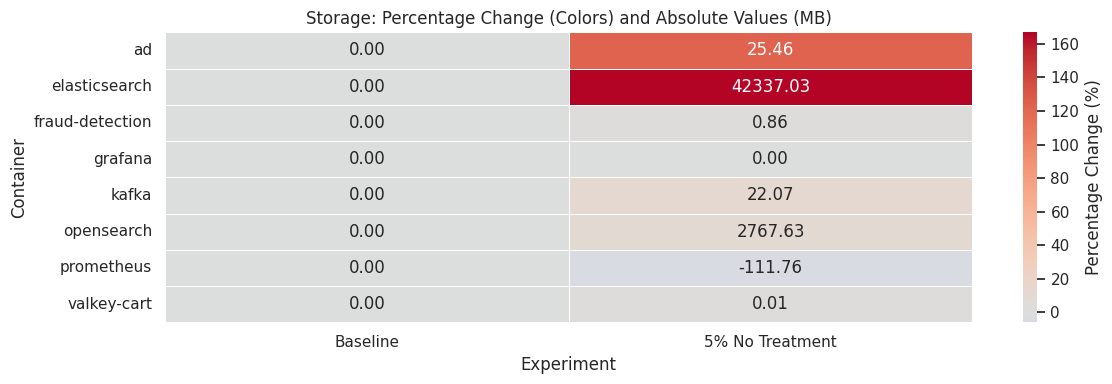

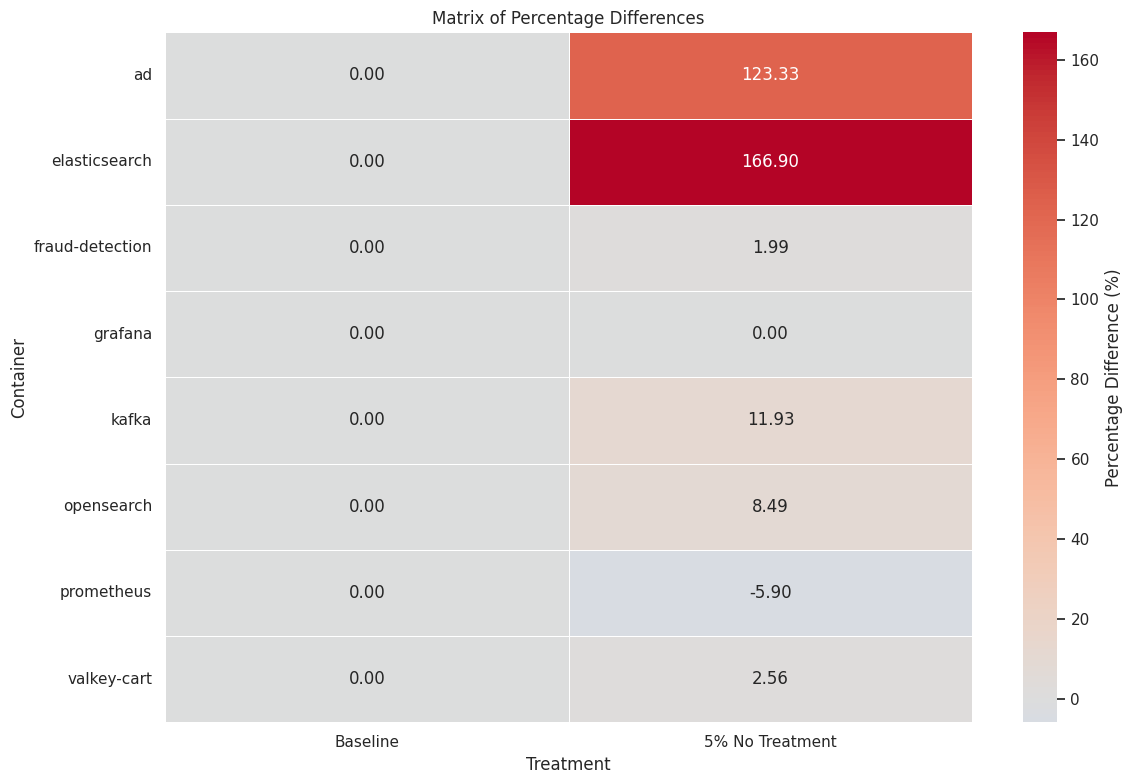

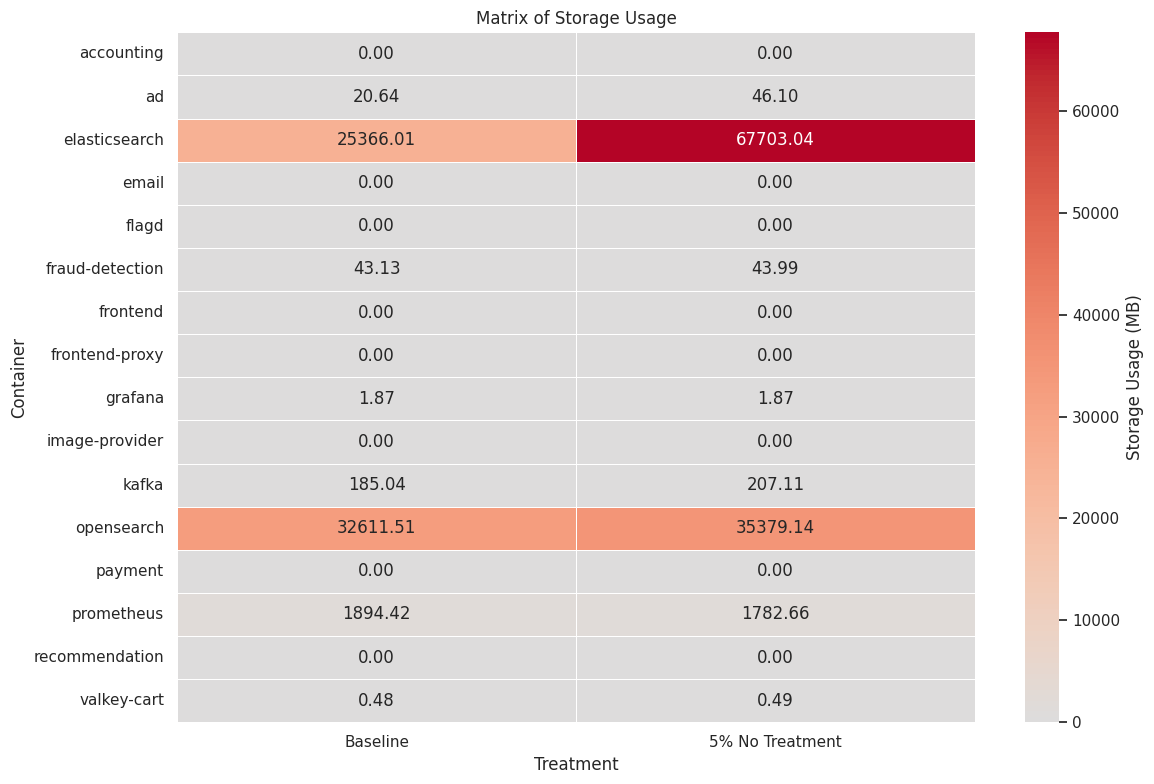

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_difference_matrix_percentage(
    base_dict,
    five_no_treatment_dict,
    value_index=2,
    figsize=(12, 8)
):
    """
    Heatmap of percentage differences from baseline for "5% No Treatment".
    """
    # Identify common containers
    common = set(base_dict) & set(five_no_treatment_dict)
    if not common:
        raise ValueError("No common containers found in base and 5% No Treatment dicts.")

    # Build DataFrame
    data = {
        'Baseline': {c: base_dict[c][value_index] for c in common},
        '5% No Treatment': {c: five_no_treatment_dict[c][value_index] for c in common},
    }
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Compute percentage difference from baseline
    pct = df.sub(df['Baseline'], axis=0).div(df['Baseline'], axis=0).mul(100)
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    pct.dropna(how='any', inplace=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        pct,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix(
    base_dict,
    five_no_treatment_dict,
    value_index=2,
    figsize=(12, 8)
):
    """
    Heatmap of absolute storage usage in MB for baseline and 5% No Treatment.
    """
    # Identify common containers
    common = set(base_dict) & set(five_no_treatment_dict)
    if not common:
        raise ValueError("No common containers found in base and 5% No Treatment dicts.")

    # Build DataFrame
    data = {
        'Baseline': {c: base_dict[c][value_index] for c in common},
        '5% No Treatment': {c: five_no_treatment_dict[c][value_index] for c in common},
    }
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Convert bytes -> MB
    df_mb = (df / 1e6).round(2)
    df_mb.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_mb.dropna(how='any', inplace=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        df_mb,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Storage Usage (MB)'}
    )
    plt.title("Matrix of Storage Usage")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix_baseline(
    base_dict,
    five_no_treatment_dict,
    value_index=2,
    figsize=(12, 4)
):
    """
    Heatmap showing percentage change from baseline
    with absolute MB differences annotated, for 5% No Treatment.
    """
    # Identify common containers
    common = set(base_dict) & set(five_no_treatment_dict)
    if not common:
        raise ValueError("No common containers found in base and 5% No Treatment dicts.")

    # Build DataFrame
    data = {
        'Baseline': {c: base_dict[c][value_index] for c in common},
        '5% No Treatment': {c: five_no_treatment_dict[c][value_index] for c in common},
    }
    idx = sorted(common)
    df = pd.DataFrame(data, index=idx)

    # Convert bytes -> MB
    df_mb = (df / 1e6).round(2)

    # Percentage change
    pct = df_mb.sub(df_mb['Baseline'], axis=0).div(df_mb['Baseline'], axis=0).mul(100)
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    pct.dropna(how='any', inplace=True)

    # Absolute MB difference for annotations
    abs_diff = df_mb.sub(df_mb['Baseline'], axis=0).loc[pct.index]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        pct,
        annot=abs_diff,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change (%)'}
    )
    plt.title("Storage: Percentage Change (Colors) and Absolute Values (MB)")
    plt.xlabel("Experiment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


generate_difference_matrix_baseline(
    values_base_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
)

generate_difference_matrix_percentage(
    values_base_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
)

generate_difference_matrix(
    values_base_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
)



In [33]:
report_base_storage_per_namespace = load_report_interactions(report_directory, report_names[0], "cadvisor_storage_usage_combined_absolute", "empty_treatment")
report_sampling_5_percent_storage_per_namespace = load_report_interactions(report_directory, report_names[3], "cadvisor_storage_usage_combined_absolute", "empty_treatment")


[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=Metr

In [34]:
def get_storage_energy_consumption_per_namespace(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["namespace"].unique())
    print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("namespace"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]
    
        
        if not treatment_df.empty:
           # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_storage_usage_combined_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_storage_usage_combined_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")
            # set to 0 if no treatment period found
            treatment_start_end_values[container_name] = (-1, -1, -1)

    return treatment_start_end_values

values_base_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_base_storage_per_namespace, "empty_treatment")
values_sampling_5_percent_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_sampling_5_percent_storage_per_namespace, "empty_treatment")

for container_name, values in values_base_storage_per_namespace.items():
    if not container_name in values_sampling_5_percent_storage_per_namespace:
        print(f"Container {container_name} not found in all treatments.")
        continue
    percentage_differece_sampling = (values_sampling_5_percent_storage_per_namespace[container_name][2] - values_base_storage_per_namespace[container_name][2]) / values_base_storage_per_namespace[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {values_base_storage_per_namespace[container_name][2]}")
    print(f"Sampling 5% Treatment: {values_sampling_5_percent_storage_per_namespace[container_name][2]} ({percentage_differece_sampling:.2f}%)")
    
    print("-----------------------------------------------")

Interaction: empty_treatment with 1 containers
Interaction: empty_treatment with 1 containers
Container: system-under-evaluation
Base Treatment: 55891644416
Sampling 5% Treatment: 631038681088 (1029.04%)
-----------------------------------------------


In [43]:
def mean_of_experiments_of_type(dataframes, response_name, container_key='label_app_kubernetes_io_name'):
    """     print(dataframes)
        #print(dataframes.columns) AttributeError: 'list' object has no attribute 'columns'
        print(dataframes[0])
        print(dataframes[0].columns)
        for df in dataframes:
            combined_df = pd.concat(dataframes, ignore_index=True)
        print(combined_df)
        
    """
    # Compute aggregated statistics by rounding experiment_seconds
    dataframes['rounded_experiment_seconds'] = dataframes['experiment_seconds'].round(0)
    agg_df = (
        combined_df
        .groupby([container_key, 'rounded_experiment_seconds'])[response_name]
        .agg(['mean', 'std'])
        .reset_index()
    )
    return agg_df

def plot_sum_aggregated_all_containers(combined_df, response_name, treatment_end_time, treatment_start_time, report_name_key="report_name", time_key="rounded_experiment_seconds", interpolation_kind="cubic"):
    """
    Plots a single graph that aggregates (sums up) data across all containers for each report name.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name for the y-axis (e.g. metric to plot).
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        report_name_key (str): Column name representing report names (default "report_name").
        time_key (str): Column name representing time (default "rounded_experiment_seconds").
        interpolation_kind (str): Interpolation method to use (default "cubic").
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.interpolate import interp1d

    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Aggregate the data across containers for each report by summing the response metric
    aggregated_df = combined_df.groupby([report_name_key, time_key])[response_name].sum().reset_index()
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    plt.figure(figsize=(15, 7))
    
    # Loop through each report name and plot the aggregated treatment curve
    for report in aggregated_df[report_name_key].unique():
        df = aggregated_df[aggregated_df[report_name_key] == report].sort_values(by=time_key)
        if len(df) > 1:
            # Interpolate the aggregated response for a smoother curve
            f = interp1d(df[time_key], df[response_name], kind=interpolation_kind)
            time_new = np.linspace(df[time_key].min(), df[time_key].max(), num=500)
            response_interpolated = f(time_new)
            sns.lineplot(x=time_new, y=response_interpolated, label=report, linewidth=2)
        else:
            print(f"Only one data point for report '{report}'.")
    
    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
    
    plt.title("Aggregated Sum of All Containers by Report Name")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel(response_name)
    plt.xlim(-500, treatment_end_seconds + 500)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_percentage_difference_all_containers(combined_df, response_name, treatment_end_time, treatment_start_time, time_key="rounded_experiment_seconds"):
    """
    Plots a single graph of the average percentage uncertainty (calculated as (std/mean)*100)
    across all containers at each time point.
    
    The function first computes the uncertainty percentage for each row and then groups 
    the data by the time key to average these percentages.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name of the metric (for clarity; the calculation uses 'mean' and 'std').
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        time_key (str): Column name representing time (default "rounded_experiment_seconds").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Compute percentage uncertainty for each row
    df = combined_df.copy()
    df['uncertainty_pct'] = np.where(
        df['mean'] != 0,
        (df['std'] / df['mean']) * 100,
        0
    )
    
    # Aggregate by taking the average uncertainty percentage across containers for each time point
    agg_df = df.groupby(time_key)['uncertainty_pct'].mean().reset_index()
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create the single plot
    plt.figure(figsize=(15, 7))
    sns.lineplot(
        x=time_key,
        y='uncertainty_pct',
        data=agg_df,
        marker='o',
        label='Average Uncertainty (%)'
    )
    
    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
    
    plt.title("Aggregated Average Percentage Uncertainty Across All Containers")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel("Average Uncertainty (%)")
    plt.xlim(-500, treatment_end_seconds + 500)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_percentage_difference_mean(combined_condensed_df, treatment_end_time, treatment_start_time):
      
    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get the baseline data
    baseline_df = combined_condensed_df[combined_condensed_df["report_name"] == "recommendation_k8_base_1m_otel"]

    # Merge the baseline data with the other treatments
    baseline_df = baseline_df.rename(columns={"mean": "baseline"})
    merged_df = pd.merge(combined_condensed_df, baseline_df[["rounded_experiment_seconds", "baseline"]], on="rounded_experiment_seconds")

    # Calculate the percentage difference for each treatment relative to the baseline
    merged_df["percentage_difference"] = (merged_df["mean"] - merged_df["baseline"]) / merged_df["baseline"] * 100

    # Plot the percentage difference for each treatment
    plt.figure(figsize=(15, 7))
    sns.lineplot(
        x="rounded_experiment_seconds",
        y="percentage_difference",
        hue="report_name",
        data=merged_df,
        marker='o'
    )
    plt.axhline(y=0, color="r", linestyle="--")

    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    plt.title("Percentage Difference from Baseline for All Treatments")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel("Percentage Difference (%)")
    # only show the range from 0 - 20
    plt.ylim(-150, 150)
    plt.grid(True)
    plt.legend(title="Treatment")
    plt.tight_layout()
    plt.show()


In [41]:
experiment_report_cache = {}

Found 7 recommendation_k8_base_1m_otel experiments
Using cached dataframes.
Found 6 recommendation_k8_base_1s_otel experiments
Using cached dataframes.
Found 6 recommendation_k8_base_5_percent experiments
Using cached dataframes.
Found 6 recommendation_k8_base_10_percent experiments
Using cached dataframes.
Found 6 recommendation_k8_base_50_percent experiments
Using cached dataframes.
     label_app_kubernetes_io_name  rounded_experiment_seconds           mean  \
0                      accounting                      -300.0  786432.000000   
1                      accounting                      -270.0  786432.000000   
2                      accounting                      -240.0  786432.000000   
3                      accounting                      -210.0  786432.000000   
4                      accounting                      -180.0  425164.800000   
...                           ...                         ...            ...   
4256                  valkey-cart                   

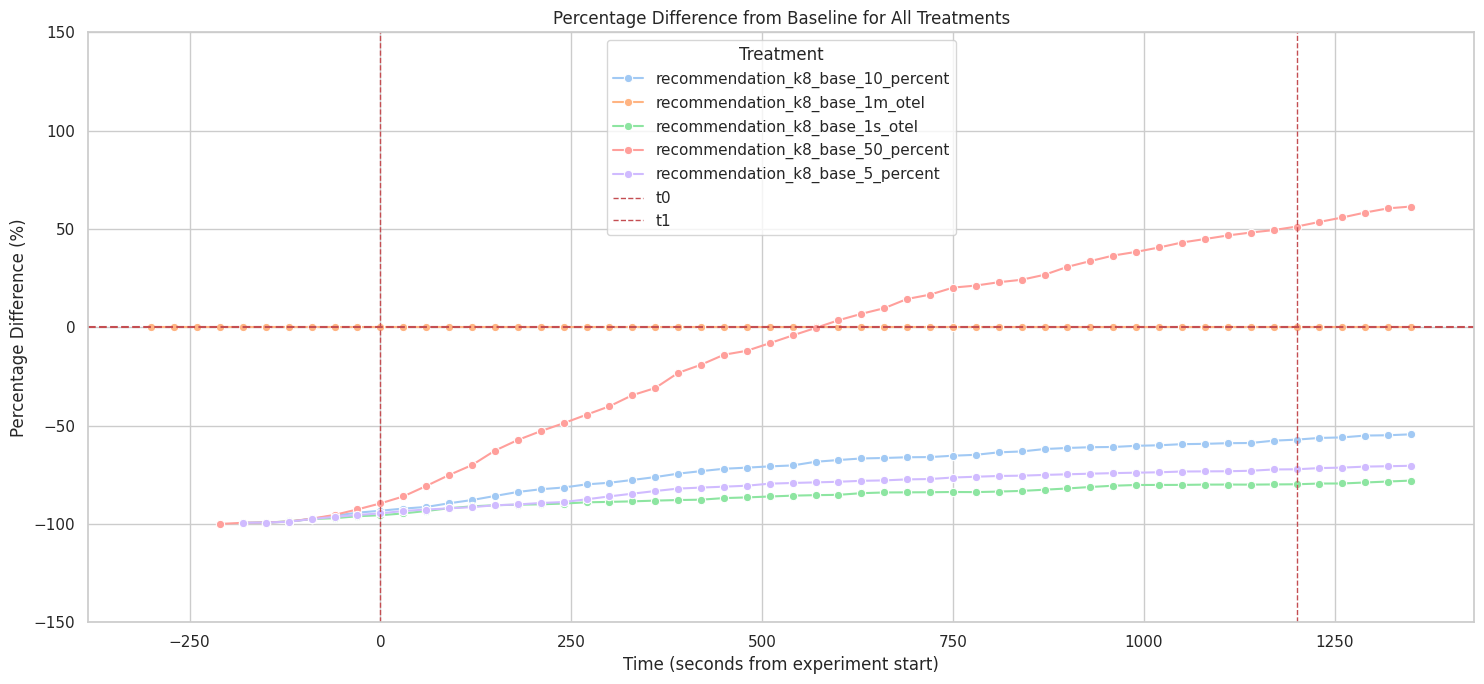

In [44]:


response_name = "cadvisor_storage_usage_all_absolute"
report_directory = "reports"
treatment_names = ["empty_treatment", "delay_treatment"]


files_in_direcotory = listdir("reports")

# sort them by date
files_in_direcotory.sort(key=lambda x: path.getctime(path.join("reports",x)))
files_in_direcotory = files_in_direcotory[::-1]

experiments_map = {
    "recommendation_k8_base_1m_otel": [],
    "recommendation_k8_base_1s_otel": [],
    "recommendation_k8_base_5_percent": [],
    "recommendation_k8_base_10_percent": [],
    "recommendation_k8_base_50_percent": [],
}

mean_combined_df = {}


# (Re)initialize the experiments_map values to empty lists if needed.
for experiment in experiments_map.keys():
    experiments_map[experiment] = []

# Loop over each file just once.
for file in yaml_files:
    report_path = path.join("reports", file)
    with open(report_path, "r") as f:
        content = f.read()
    # Check the file content against each experiment.
    for experiment in experiments_map.keys():
        if experiment in content:
            experiments_map[experiment].append(file)

# Process each experiment as before.
for experiment, report_names in experiments_map.items():
    print("Found " + str(len(report_names)) + " " + experiment + " experiments")

    REPORT_LABELS = {report: report for report in report_names}

    if experiment not in experiment_report_cache:
        experiment_report_cache[experiment] = None

    (experiment_report_cache[experiment], combined_df, 
     treatment_start_time, treatment_end_time) = load_reports_and_normalize_time(
         experiment_report_cache[experiment], report_directory, 
         response_name, treatment_names, report_names)

    mean_combined_df[experiment] = mean_of_experiments_of_type(combined_df, response_name)
    # Replace the report name with the experiment name.
    mean_combined_df[experiment]['report_name'] = experiment



#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

combined_df = pd.concat(mean_combined_df.values(), ignore_index=True)
print(combined_df)

combined_df["experiment_seconds"] = combined_df["rounded_experiment_seconds"]



combined_condensed_df = combined_df.groupby(["report_name", "rounded_experiment_seconds"])["mean"].sum().reset_index()


plot_percentage_difference_mean(combined_condensed_df, treatment_end_time, treatment_start_time)
